In [1]:
#### Gather, MSU's roster data for analysis

url = 'https://www.collegehockeynews.com/reports/roster/Michigan-State/32'

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import re

response = requests.get(url)
html_content = response.text


In [2]:
# Updated function to parse the college hockey roster HTML table and perform transformations

# Function to split "Last Team" into "Team" and "League" with edge case handling
def split_last_team(last_team):
    # Use regular expression to extract team and league
    match = re.search(r'(.+) \((.+)\)', last_team)
    if match:
        return match.groups()
    else:
        # If no league is specified, return the team as is and leave league blank
        return last_team, ""

# Updated function to correctly capture the player's position and handle edge cases in "Last Team"
def parse_and_transform_roster(html_content):
    # Initialize BeautifulSoup object
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Find the table with the roster
    roster_table = soup.find('table', {'id': 'players'})
    
    # Extract headers
    header_row = roster_table.find('thead').find('tr')
    headers = [header.text.strip() for header in header_row.find_all('th')]
    headers.append('Position')  # Add the Position column to headers
    
    # Initialize data list and current_position variable
    data = []
    current_position = None  # Initialize as None to later filter out irrelevant rows
    
    # Iterate through each row in the table
    for row in roster_table.find_all('tr'):
        if 'class' in row.attrs and 'stats-section' in row.attrs['class']:
            current_position = row.text.strip()
        else:
            cells = row.find_all('td')
            if cells and current_position:
                row_data = [cell.text.strip() for cell in cells]
                row_data.append(current_position)  # Add the current position to the row data
                data.append(row_data)
    
    # Create DataFrame
    df = pd.DataFrame(data, columns=headers)
    
    # Cleanup: Remove rows where 'No.' column is not numeric
    df = df[df['No.'].str.isnumeric()]
    
    # Cleanup: Drop the 'Pos' column
    df.drop(columns=['Pos'], inplace=True)
    
    # Transform Height to Inches
    df['Height_Inches'] = df['Ht.'].apply(convert_to_inches)

    # Transform NHL Draft to Draft_Year, NHL_Team, and D_Round
    df['Draft_Year'], df['NHL_Team'], df['D_Round'] = zip(*df['NHL Draft'].apply(split_nhl_draft))
    df.drop(columns=['NHL Draft'], inplace=True) # Drop the original NHL Draft column
    
    # Handle edge cases in "Last Team" to split into "Team" and "League"
    df['Team'], df['League'] = zip(*df['Last Team'].apply(split_last_team))
    df.drop(columns=['Last Team'], inplace=True)
    
    # Rename the trouble column Hometown\nLast Team\nNHL Draft
    df.rename(columns={'Hometown\nLast Team\nNHL Draft': 'Hometown'}, inplace=True)

    # assign data types No. Wt. and Height_Inches to int, DOB to datetime
    int_list = ['No.', 'Wt.', 'Height_Inches']
    df[int_list] = df[int_list].astype(int)

    df['DOB'] = pd.to_datetime(df['DOB'], errors='coerce')
    
    return df

# Function to split "NHL Draft" into "Draft_Year", "NHL_Team", and "D_Round"
def split_nhl_draft(nhl_draft):
    try:
        draft_year, nhl_team, d_round = nhl_draft.split('-')
        return draft_year, nhl_team, d_round
    except ValueError:
        # Handle missing or incomplete data
        return None, None, None

# # Test the function
# test_values = ['2022-WSH-7', '', '2021-DET']
# [split_nhl_draft(val) for val in test_values]



# Function to convert height in "ft-in" format to total inches
def convert_to_inches(height_str):
    try:
        feet, inches = map(int, height_str.split('-'))
        return (feet * 12) + inches
    except ValueError:
        return None
    
# Example of how to call the function with a URL (this is just a code snippet and won't run here)
# import requests
# url = "https://example.com/roster_page"

response = requests.get(url)
html_content = response.text
# df = parse_and_transform_roster(html_content)

# Use the function to parse and transform the roster using the already available HTML content
parsed_and_transformed_df = parse_and_transform_roster(html_content)
parsed_and_transformed_df.head()


,,No.,Name,Yr.,Ht.,Wt.,DOB,Hometown,Position,Height_Inches,Draft_Year,NHL_Team,D_Round,Team,League
0,,9,"Basgall, Matt",So,5-9,190,2002-08-16,"Lake Forest, Ill.",Defensemen,69,None,None,None,Tri-City,USHL
1,,24,"Crossman, James",Sr,6-3,200,1998-11-23,"Denver, Colo.",Defensemen,75,None,None,None,Odessa,NAHL
2,,2,"Geary, Patrick",Fr,6-1,185,2004-02-18,"Hamburg, N.Y.",Defensemen,73,None,None,None,Waterloo,USHL
3,,7,"Gucciardi, David",Jr,6-1,190,2002-10-09,"Toronto, Ont.",Defensemen,73,2022,WSH,7,Waterloo,USHL
4,,3,"Hurtig, Viktor",So,6-6,191,2002-04-28,"Falun, Sweden",Defensemen,78,None,None,None,Växjö Lakers HC J20,


In [3]:
######### Simple Map of Hometowns

from geopy.geocoders import Nominatim
import geopandas as gpd
import matplotlib.pyplot as plt

df = parsed_and_transformed_df

# Initialize geocoder
geolocator = Nominatim(user_agent="hockey_hometowns")

# Geocode hometowns to get latitude and longitude
df['Coordinates'] = df['Hometown'].apply(geolocator.geocode).apply(lambda loc: tuple(loc.point) if loc else None)

# Split coordinates into latitude and longitude
df[['Latitude', 'Longitude', '_']] = pd.DataFrame(df['Coordinates'].tolist(), index=df.index)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))


C:\Users\Justin\AppData\Local\Temp\ipykernel_15964\875272646.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


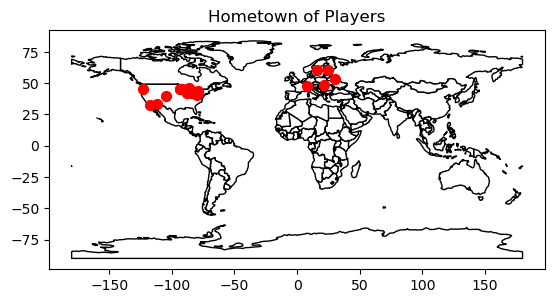

C:\Users\Justin\AppData\Local\Temp\ipykernel_15964\875272646.py:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


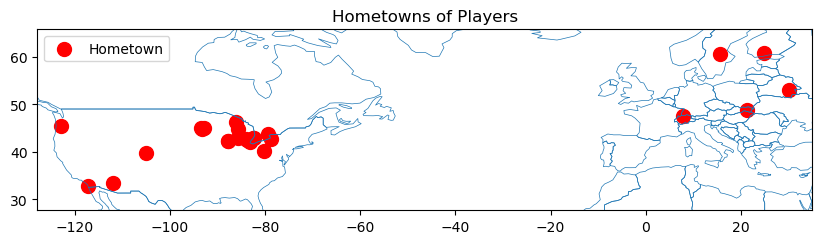

In [4]:

################# PLOTS ######################
# Plot the map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black')
gdf.plot(ax=ax, marker='o', color='red', markersize=50)
plt.title("Hometown of Players")
plt.show()

############## PLOT 2 #######################
# Plot the map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Get bounding box to zoom into
minx, miny, maxx, maxy = gdf.geometry.total_bounds
ax = world.boundary.plot(figsize=(10, 10), linewidth=0.5)
ax.set_xlim(minx - 5, maxx + 5)
ax.set_ylim(miny - 5, maxy + 5)

# Plot the points
gdf.plot(ax=ax, markersize=100, color='red', marker='o', label='Hometown')
plt.title('Hometowns of Players')
plt.legend()
plt.show()


In [6]:
#### FOLIUM PLOTS #####

import folium

# Create a base map
m = folium.Map(location=[40, -100], zoom_start=4)

# Sample data (replace with your DataFrame)

sample_data = gdf.to_dict('records')


# Add points to the map
for row in sample_data:
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=row['Hometown'],
        icon=None  # Can change the icon here
    ).add_to(m)

# Show the map
# m


In [7]:
import folium

# Create a base map with a different tileset
m = folium.Map(location=[40, -100], zoom_start=4, tiles='Stamen Terrain')

# Sample data (replace with your DataFrame)
sample_data = gdf.to_dict('records')
# Add custom markers to the map
for row in sample_data:
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"<strong>{row['Hometown']}</strong>",
        icon=folium.Icon(color='blue', icon='cloud')
    ).add_to(m)

# Add a circle marker with a text label
folium.CircleMarker(
    location=[42.3601, -71.0589],
    radius=10,
    color='red',
    fill=True,
    fill_opacity=0.4,
).add_to(m)

folium.map.Marker(
    [42.3601, -71.0589],
    icon=folium.DivIcon(icon_size=(150, 36), icon_anchor=(0, 0),
        html='<div style="font-size: 24pt">Boston</div>'),
    ).add_to(m)

# Show the map
# m


In [ ]:
## build roster urls for all teams in results data 
# hometeams

roster_base_url = 'http://www.collegehockeynews.com/reports/roster/'

team_element = 


In [ ]:
df = parsed_and_transformed_df

len(df)

df.dtypes